### README

#### Energy Drought Analysis

**Overview**

This notebook provides a comprehensive analysis of energy droughts per country, and their association with different weather regimes. It also analyses the meteorological conditions during these energy droughts. The analysis is done for different drought intensities, ranging from medium to extreme.

#### Instructions

**Prerequisites**
- Ensure that the required Python libraries, including `numpy`, `matplotlib`, `cartopy`, and custom utilities (`utils.py` and `plot_utils.py`), are installed.

**Configuration**
1. **File Paths:** Modify the paths (`ENERGY_PATH`, `ANOM_PATH`, `PSL_PATH`) according to the location of your energy and meteorological datasets.
2. **Analysis Parameters:** Adjust the parameters related to the analysis, such as the window size, variable type, meteorological_variable to plot, and cluster ordering.
3. **Output Directories:** Update the output directories (`dir_Output`, `dir_Figures`, `dir_MeteoFigures`) to specify where the results and figures will be saved.

**Author**

Bram van Duinen

**Date (last modified)**

2024-01-19

### 1. Preliminaries

In [1]:
import utils as ut
import plot_utils as put

import numpy as np
from datetime import datetime
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#### Options to change!

In [2]:
ENERGY_PATH = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'
ANOM_PATH = '/net/pc230050/nobackup/users/duinen/LENTIS/present/'
PSL_PATH = '/net/pc200256/nobackup/users/most/LENTIS/present/day/psl_d/'
WINDOW = 7
VARIABLE = 'residual' # option 2: total_RE
DTYPE = 'tas' # to show in meteo-plots, choose from tas_d, sfcWind_d, rsds_d
CLUSTER_NAMES = {0: 'NAO -', 1: 'NAO +', 2: 'Blocking', 3: 'Atl. Ridge'} # make sure to change after new clustering run!
drop_no_regime = True # set to true if  you want to drop events that occur under 'No-regime' weather regime

date_now = datetime.now()
rundate = '%4.4i%2.2i%2.2i' % (date_now.year,date_now.month,date_now.day)
dir_Output = f'../Results/Data/{rundate}/{VARIABLE}/droughts_per_wr/'
dir_Figures = f'../Results/Figures/{rundate}/{VARIABLE}/droughts_per_wr/'
dir_MeteoFigures = f'../Results/Figures/{rundate}/{VARIABLE}/meteo_per_wr/'

In [3]:
ut.check_make_dir(dir_Output)
ut.check_make_dir(dir_Figures)
ut.check_make_dir(dir_MeteoFigures)

data_stacked = ut.load_data(ENERGY_PATH, VARIABLE)
data_rank = data_stacked.compute().rank(dim='event', pct=True)

if VARIABLE == 'total_RE':
    data_rank = 1 - data_rank

df_raw = ut.merge_cluster_data(cluster_path = "../Results/clusters_v3/clusters_all.csv", data_rank = data_rank)

if drop_no_regime:
    df = df_raw[df_raw['cluster_id'] != 4] # remove cluster 4, which is no-regime
    print(f'Fraction of data that was no-regime: {(len(df_raw) - len(df) ) / len(df_raw):.2f} is removed')
else:
    df = df_raw.copy()

Creating dir ../Results/Data/20240202/residual/droughts_per_wr/
Creating dir ../Results/Figures/20240202/residual/droughts_per_wr/
Creating dir ../Results/Figures/20240202/residual/meteo_per_wr/
Fraction of data that was no-regime: 0.08 is removed


### 2. Define functions

In [4]:
def cluster_histogram_list(df, country_list, ax):
    """
    Plot the distribution of energy droughts per weather regime

    Parameters:
        df (pd.DataFrame): DataFrame containing the energy data per country, and the corresponding weather regimes.
        country_list (list): List of country names to filter the data.
        ax (matplotlib.axes.Axes): Matplotlib axes to plot on.

    Returns:
        None
    """
    df_mild = df.query('country_name in @country_list and residual >= 0.9 and residual < 0.95')
    df_moderate = df.query('country_name in @country_list and residual >= 0.95 and residual < 0.975')
    df_severe = df.query('country_name in @country_list and residual >= 0.975 and residual < 0.99')
    df_extreme = df.query('country_name in @country_list and residual >= 0.99')

    offsets = [-0.15, -0.05, 0.05, 0.15]

    for df_case, color, label, offset in zip([df_mild, df_moderate, df_severe, df_extreme], ['C0', 'C2', 'C1', 'C3'], ['Mild', 'Moderate', 'Severe', 'Extreme'], offsets):
        percentages = []
        for cluster_id in range(4):
            total_cases = len(df_case)
            case_percentage = len(df_case.query('cluster_id == @cluster_id')) / total_cases * 100 if total_cases > 0 else 0
            percentages.append(case_percentage)
        ax.bar([x + offset for x in range(4)], percentages, width=0.1, bottom=0, align='center', color=color, label=label)

    total_cases = len(df.query('country_name in @country_list and residual >= 0.9'))
    percentages = []
    for cluster_id in range(4):
        total_percentage = len(df.query('cluster_id == @cluster_id and country_name in @country_list and residual >= 0.9')) / total_cases * 100
        percentages.append(total_percentage)

    ax.set_xticks(range(4))
    ax.set_xticklabels([f'{CLUSTER_NAMES[0]} ({percentages[0]:.1f}%)', f'{CLUSTER_NAMES[1]} ({percentages[1]:.1f}%)', f'{CLUSTER_NAMES[2]} ({percentages[2]:.1f}%)', f'{CLUSTER_NAMES[3]} ({percentages[3]:.1f}%)'])
    ax.set_ylabel('% of events')

    ax.set_title(f'Countries: {", ".join(country_list)}')

In [5]:
def cluster_risk(df, country_list):
    """
    Calculate the risk factor (w.r.t. climatology) of energy drought events within each weather regime for a given list of countries.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        country_list (list): List of country names to filter the data.

    Returns:
        list: List of relative risks (climatology = 1) for each weather regime cluster.
    """
    df_c0 = df.query('country_name in @country_list and cluster_id == 0 and residual >= 0.9 and residual < 1')
    df_c1 = df.query('country_name in @country_list and cluster_id == 1 and residual >= 0.9 and residual < 1')
    df_c2 = df.query('country_name in @country_list and cluster_id == 2 and residual >= 0.9 and residual < 1')
    df_c3 = df.query('country_name in @country_list and cluster_id == 3 and residual >= 0.9 and residual < 1')
    df_all = df.query('country_name in @country_list and residual >= 0.9 and residual < 1')

    r_c0 = (len(df_c0)/len(df_all) * 100) / 25
    r_c1 = (len(df_c1)/len(df_all) * 100) / 25
    r_c2 = (len(df_c2)/len(df_all) * 100) / 25
    r_c3 = (len(df_c3)/len(df_all) * 100) / 25
    risks = [r_c0, r_c1, r_c2, r_c3]
    return risks

In [6]:
def plot_weather_regimes(country_name, drought_intensity, dtype, anom_data, data_psl, lons, lats, cluster_names , dataproj = ccrs.PlateCarree(), cmap = plt.cm.RdBu_r):
    """
    Plot weather regime-specific anomalies for a given country and drought intensity, save as image file.

    Parameters:
        country_name (str): Name of the country to analyze.
        drought_intensity (str): Drought intensity level ('mild', 'moderate', 'severe', 'extreme', 'all').
        dtype (str): Type of meteorological variable ('tas', 'sfcWind', 'rsds').
        anom_data (xr.Dataset): Anomalies data.
        data_psl (xr.Dataset): Surface pressure data.
        lons (np.ndarray): Longitudes array.
        lats (np.ndarray): Latitudes array.
        cluster_names (list): List of weather regime cluster names.
        dataproj (cartopy.crs.Projection, optional): Map projection. Defaults to PlateCarree.
        cmap (matplotlib.colors.Colormap, optional): Colormap for contour plot. Defaults to RdBu_r.

    Returns:
        None
    """
    drought_conditions = {
        'mild': 'residual >= 0.9 and residual < 0.95',
        'moderate': 'residual >= 0.95 and residual < 0.975',
        'severe': 'residual >= 0.975 and residual < 0.99',
        'extreme': 'residual >= 0.99',
        'all': 'residual > 0 and residual < 1'
    }

    df_intensity = df.query(f'country_name == @country_name and {drought_conditions[drought_intensity]}')

    vmin_vmax_dict = {
        'mild': {'tas': (-4, 4), 'sfcWind': (-4, 4), 'rsds': (-10, 10)},
        'moderate': {'tas': (-6, 6), 'sfcWind': (-5, 5), 'rsds': (-20, 20)},
        'severe': {'tas': (-8, 8), 'sfcWind': (-6, 6), 'rsds': (-25, 25)},
        'extreme': {'tas': (-10, 10), 'sfcWind': (-7, 7), 'rsds': (-30, 30)},
        'all': {'tas': (-3, 3), 'sfcWind': (-3, 3), 'rsds': (-10, 10)}
    }

    vmin, vmax = vmin_vmax_dict[drought_intensity][dtype]

    plot_titles = {
        'tas': ('Temperature', '[K]'),
        'sfcWind': ('Wind speed', '[m/s]'),
        'rsds': ('Solar irradiation', '[W/m2]')
    }

    title_name, cbar_unit = plot_titles[dtype]

    fig, axs = plt.subplots(2, 2, figsize=(16, 8), subplot_kw={'projection': dataproj})
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

    levels = np.linspace(vmin, vmax, 11)
    lon_lim, lat_lim = 40, 75
    for cluster_id in range(4):
        df_plot = df_intensity.query('cluster_id == @cluster_id')
        anom_plot = ut.calc_composite_mean(anom_data, df_plot)
        psl_plot = ut.calc_composite_mean(data_psl, df_plot)
        psl_plot = psl_plot / 100 # Pa to hPa
        ax = axs.flat[cluster_id]
        ax.set_extent([lons[0], lon_lim, lats[0], lat_lim])
        ax.set_ylim([lats[0], 75])

        norm = colors.BoundaryNorm(levels, ncolors=cmap.N, extend = 'both')
        im = ax.contourf(lons, lats, anom_plot, levels=levels, cmap=cmap, norm=norm, extend = 'both')
        CS = ax.contour(lons, lats, psl_plot, colors='k')
        ax.clabel(CS, inline=True, fontsize=10)
        put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, psl_plot, 'max', 50, 'H', color='k',
                       plotValue=False, transform=dataproj)
        put.plot_maxmin_points(ax, lons, lats, lon_lim, lat_lim, psl_plot, 'min', 50, 'L', color='k',
                       plotValue=False, transform=dataproj)
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        ax.set_title(f'{cluster_names[cluster_id]}')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    fig.colorbar(sm, cax=cbar_ax, label=cbar_unit)
    if drought_intensity == 'all':
        fig.suptitle(f'{title_name} anomalies per WR', fontsize=16)
    else:
        fig.suptitle(f'{title_name} anomalies per WR for {drought_intensity} events in {country_name}', fontsize=16)

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.savefig(f'{dir_MeteoFigures}{country_name}_{drought_intensity}_{dtype}_anomalies.png', dpi = 300, bbox_inches='tight')

### 3. Inspect energy characteristics per regime

Text(0.5, 1.0, 'Mean and standard deviation per cluster, for NLD')

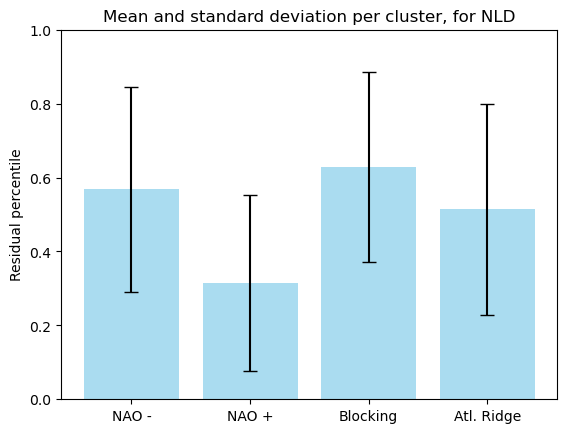

In [7]:
country_name = "NLD"

df_naomin = df.query('country_name == @country_name and cluster_id == 0')
df_naoplus = df.query('country_name == @country_name and cluster_id == 1')
df_blocking = df.query('country_name == @country_name and cluster_id == 2')
df_ridge = df.query('country_name == country_name and cluster_id == 3')

means = [
    df_naomin['residual'].mean(),
    df_naoplus['residual'].mean(),
    df_blocking['residual'].mean(),
    df_ridge['residual'].mean()
]

stds = [
    df_naomin['residual'].std(),
    df_naoplus['residual'].std(),
    df_blocking['residual'].std(),
    df_ridge['residual'].std()
]

labels = [CLUSTER_NAMES[0], CLUSTER_NAMES[1], CLUSTER_NAMES[2], CLUSTER_NAMES[3]]

fig, ax = plt.subplots()
ax.bar(labels, means, yerr=stds, capsize=5, color='skyblue', alpha=0.7)
ax.set_ylabel('Residual percentile')
ax.set_ylim(0, 1)
ax.set_title(f'Mean and standard deviation per cluster, for {country_name}')

### 4. WR distribution per energy drought type

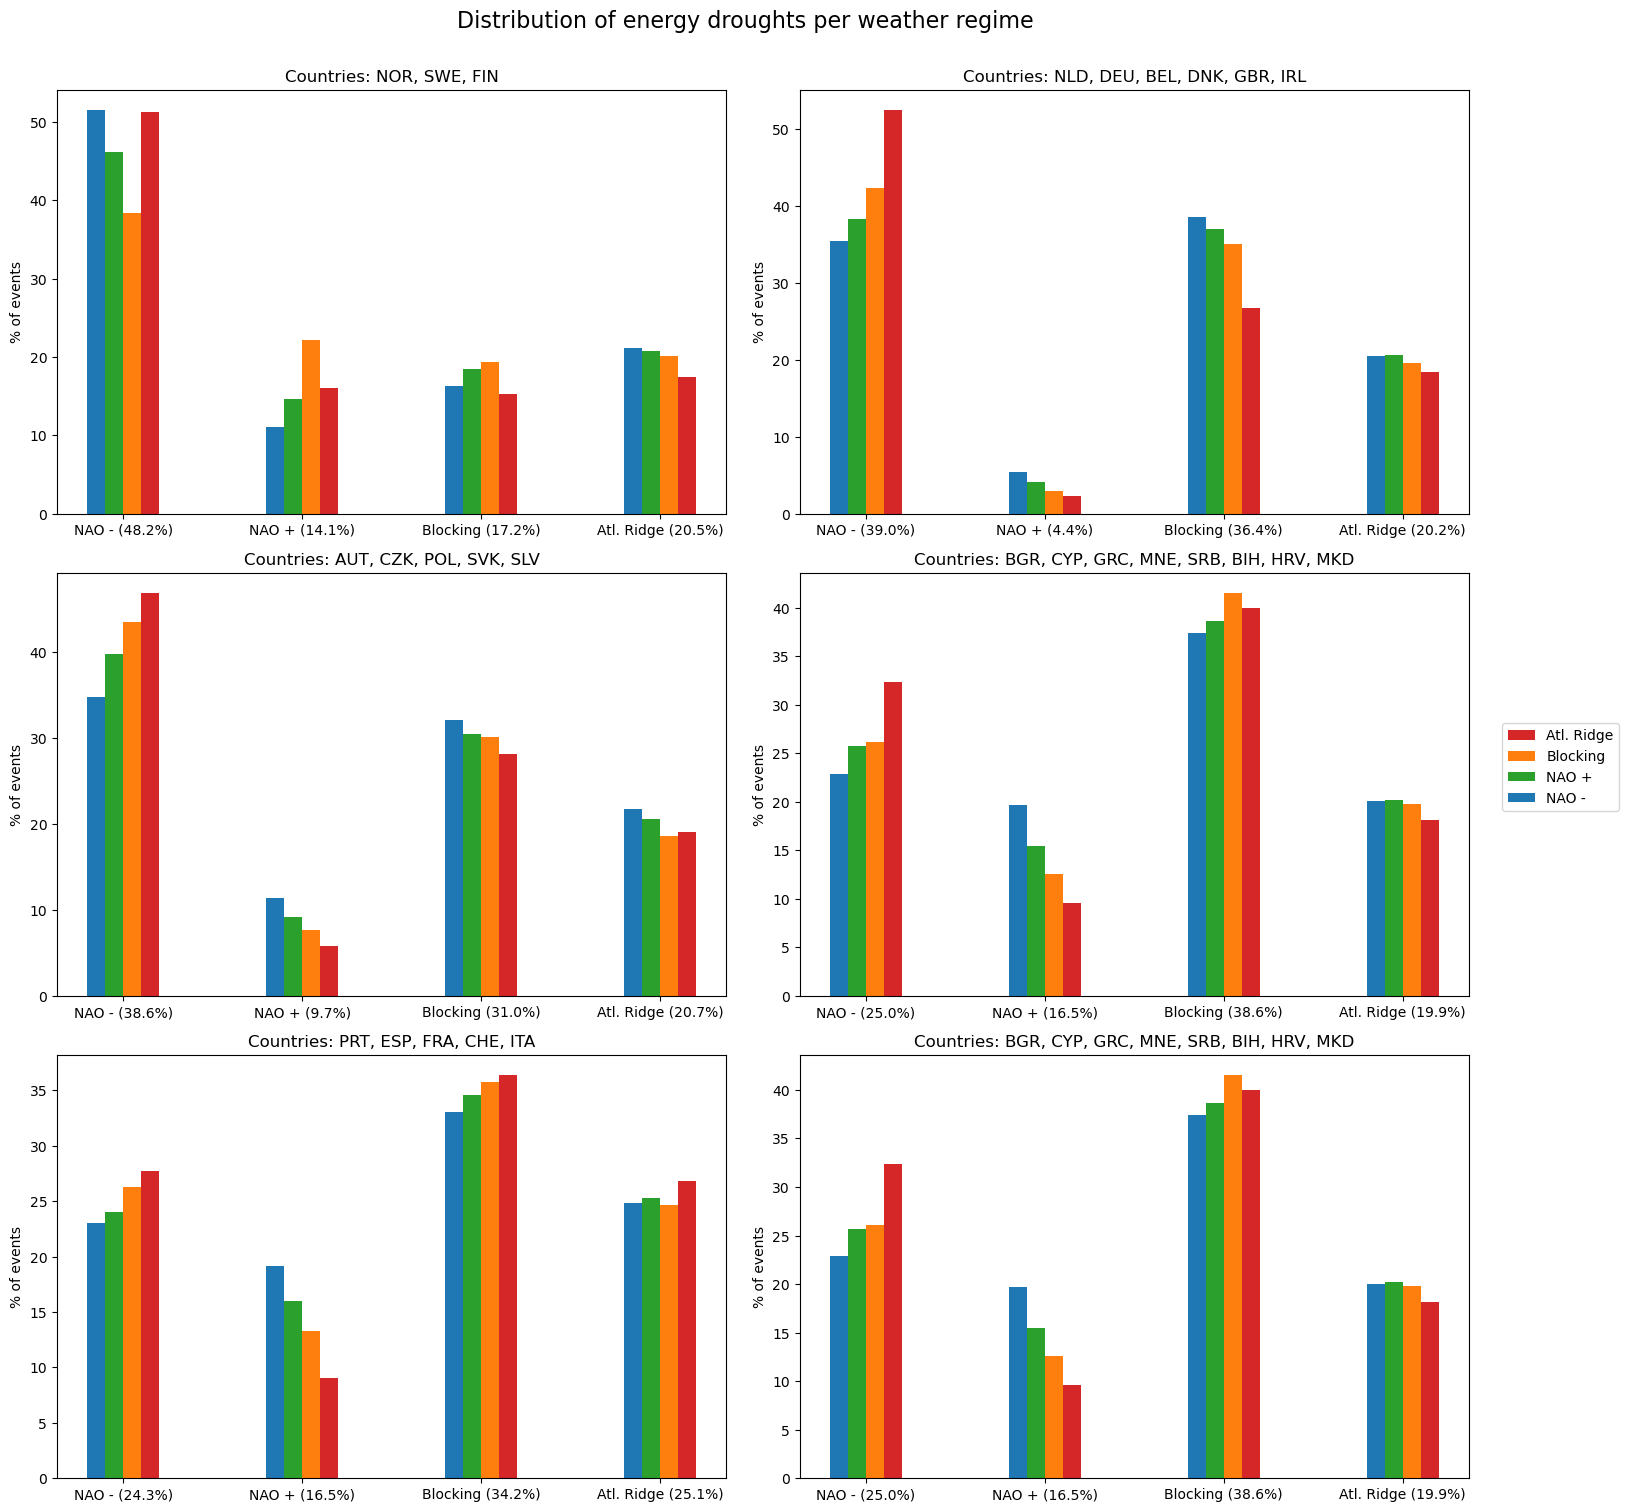

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

SW = ['PRT', 'ESP', 'FRA', 'CHE', 'ITA']
NW = ['NLD', 'DEU', 'BEL', 'DNK', 'GBR', 'IRL']
N = ['NOR', 'SWE', 'FIN']
C = ['AUT', 'CZK', 'POL', 'SVK', 'SLV']
E = ['EST',  'HON', 'ROU', 'LVA', 'LTU', 'UKR', 'MDA']
SE = ['BGR', 'CYP', 'GRC', 'MNE', 'SRB', 'BIH', 'HRV', 'MKD']

cluster_histogram_list(df, N, axs[0, 0])
cluster_histogram_list(df, NW, axs[0, 1])
cluster_histogram_list(df, C, axs[1, 0])
cluster_histogram_list(df, SE, axs[1, 1])
cluster_histogram_list(df, SW, axs[2, 0])
cluster_histogram_list(df, SE, axs[2, 1])

handles, _ = axs[0, 0].get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle( 'Distribution of energy droughts per weather regime', fontsize=16, y=1.005)
plt.tight_layout()
plt.savefig(f'{dir_Figures}droughts_per_wr_allregions_countrybased.png', dpi = 300, bbox_inches='tight')

### 5. Risk ratio per WR

In [9]:
risks_NW = cluster_risk(df, NW)
risks_SW = cluster_risk(df, SW)
risks_N = cluster_risk(df, N)
risks_C = cluster_risk(df, C)
risks_E = cluster_risk(df, E)
risks_SE = cluster_risk(df, SE)

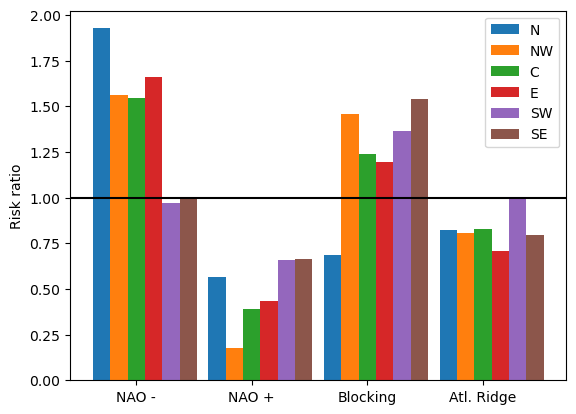

In [10]:
num_conditions = len(labels)

width = 0.15
positions = np.arange(num_conditions)

plt.bar(positions - 2*width, risks_N, width, label='N')
plt.bar(positions - width, risks_NW, width, label='NW')
plt.bar(positions, risks_C, width, label='C')
plt.bar(positions + width, risks_E, width, label='E')
plt.bar(positions + 2*width, risks_SW, width, label='SW')
plt.bar(positions + 3*width, risks_SE, width, label='SE')

plt.axhline(y=1, color='k', linestyle='-')
plt.ylabel('Risk ratio')
plt.xticks(positions, labels) 
plt.legend()
plt.savefig(f'{dir_Figures}risk_per_wr_allregions_countrybased.png', dpi = 300, bbox_inches='tight')

### 6. Plot meteo conditions for droughts by country

In [11]:
anom_data, lons, lats = ut.load_anomaly(ANOM_PATH, DTYPE)
data_psl = ut.load_psl(PSL_PATH)

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

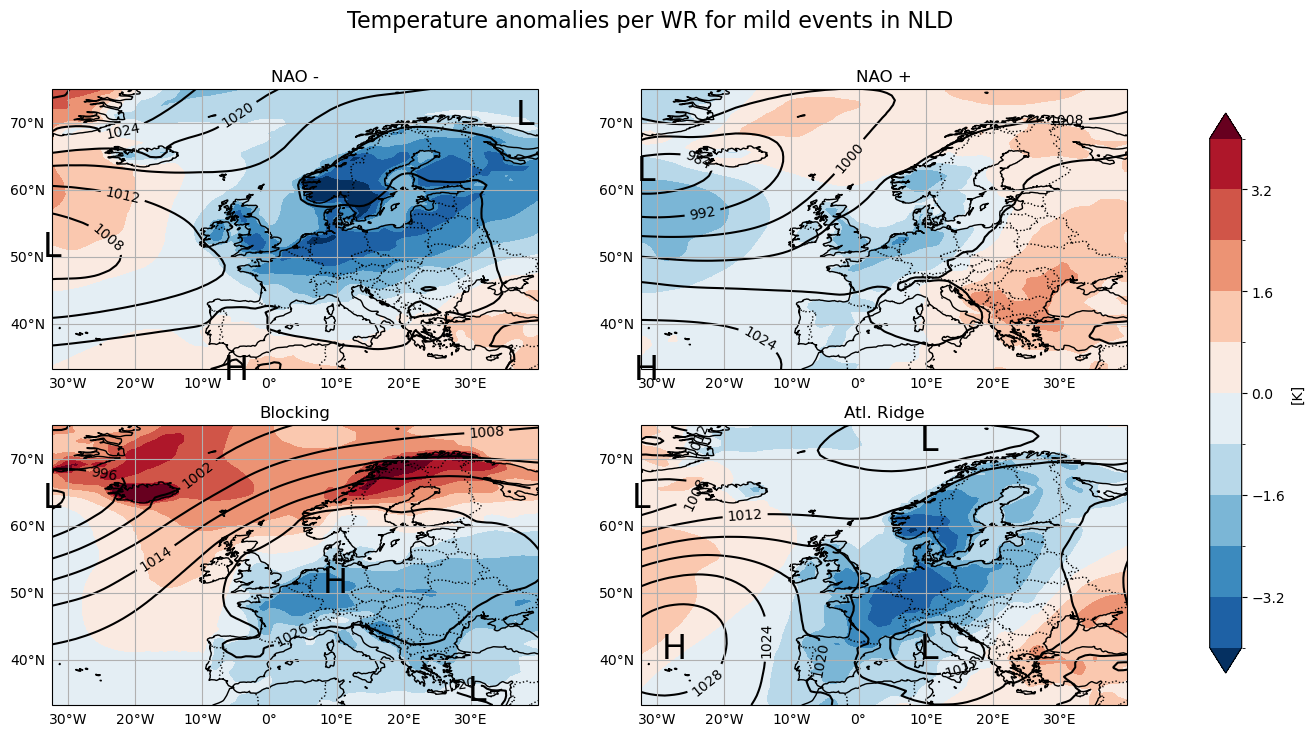

In [12]:
plot_args = [DTYPE, anom_data, data_psl, lons, lats, CLUSTER_NAMES]
plot_weather_regimes('NLD', 'mild', *plot_args)

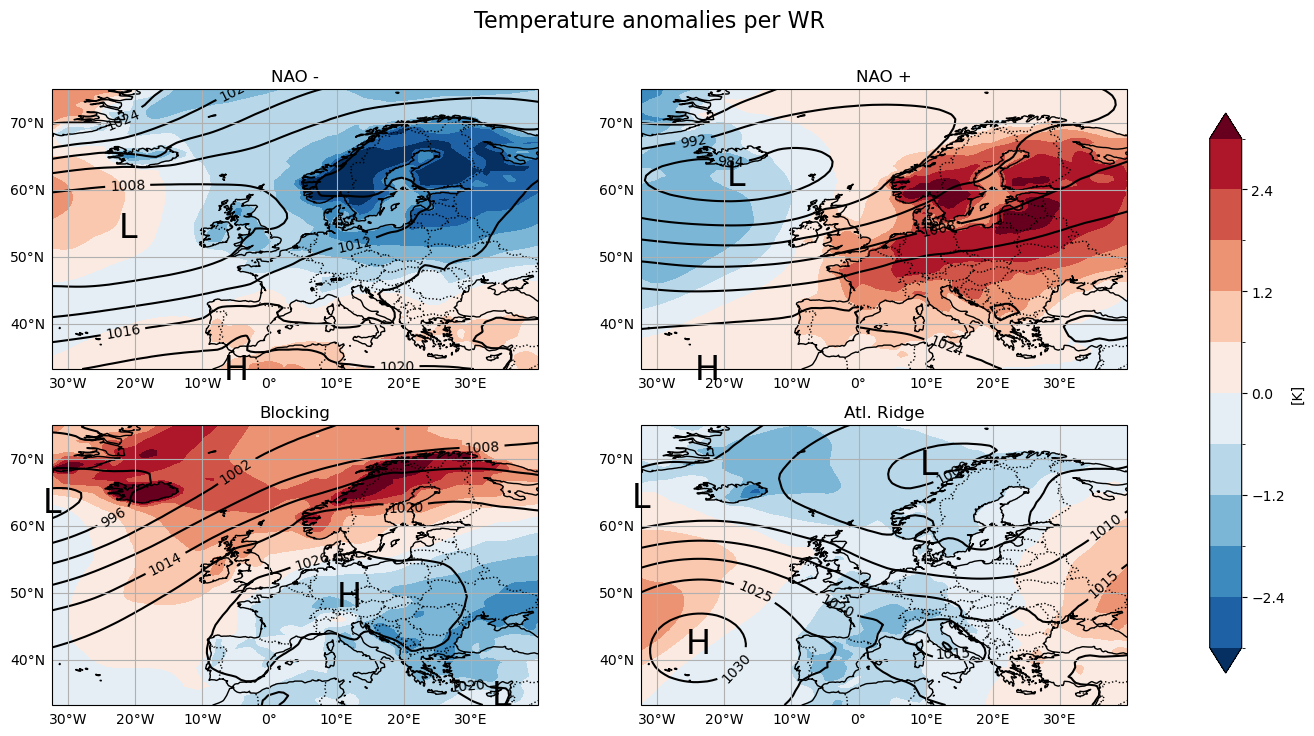

In [13]:
plot_weather_regimes('NLD', 'all', *plot_args)

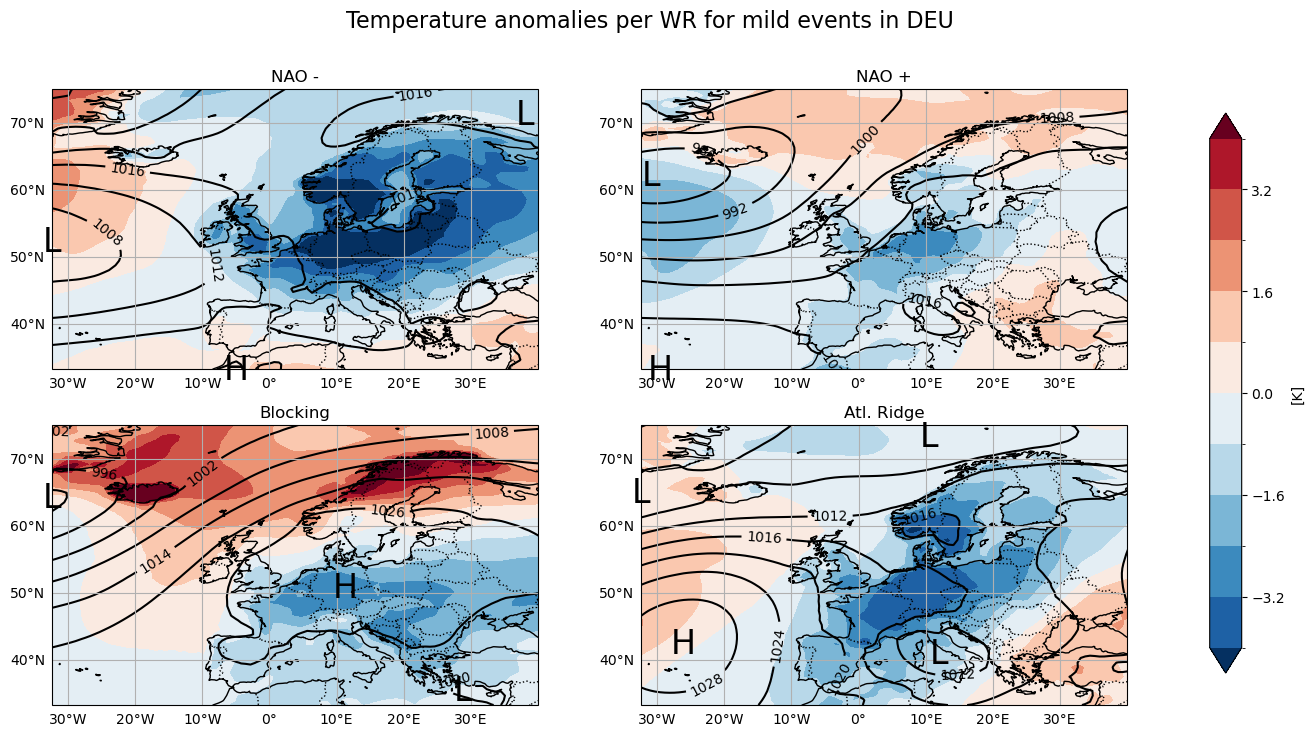

In [14]:
plot_weather_regimes('DEU', 'mild', *plot_args)

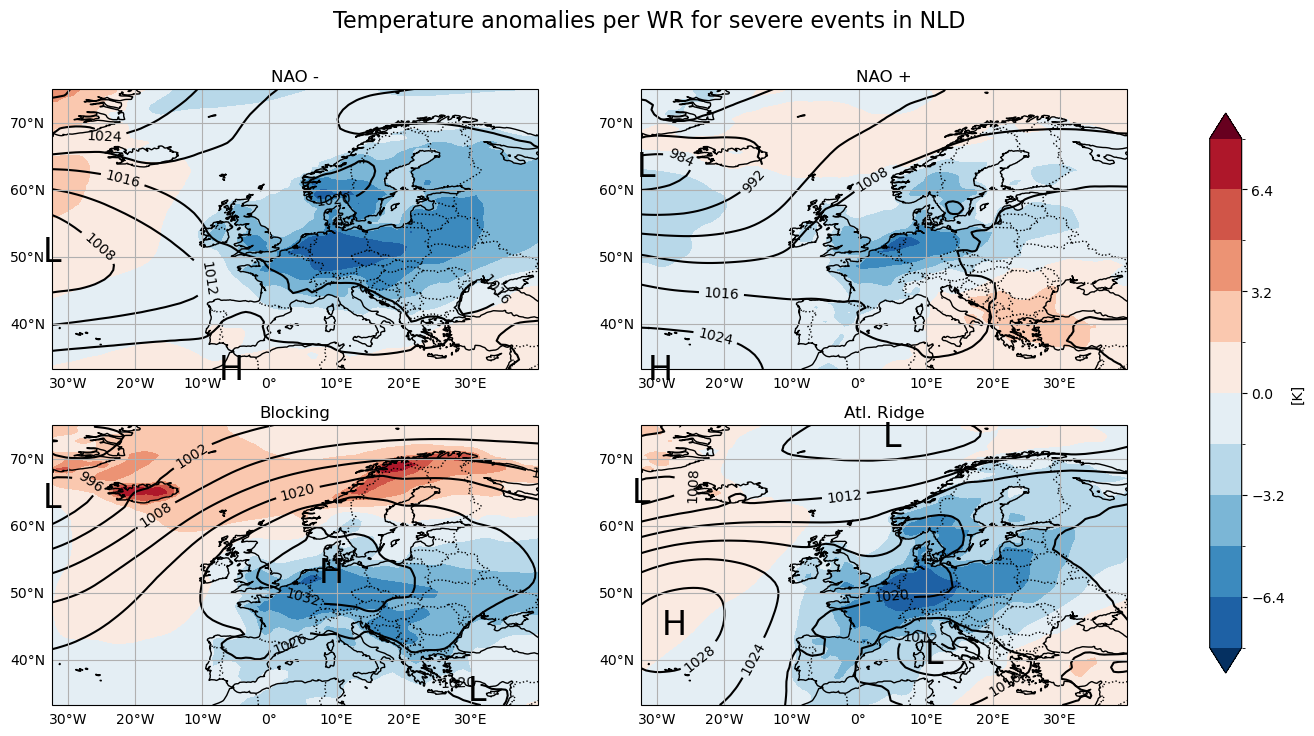

In [15]:
plot_weather_regimes('NLD', 'severe', *plot_args)

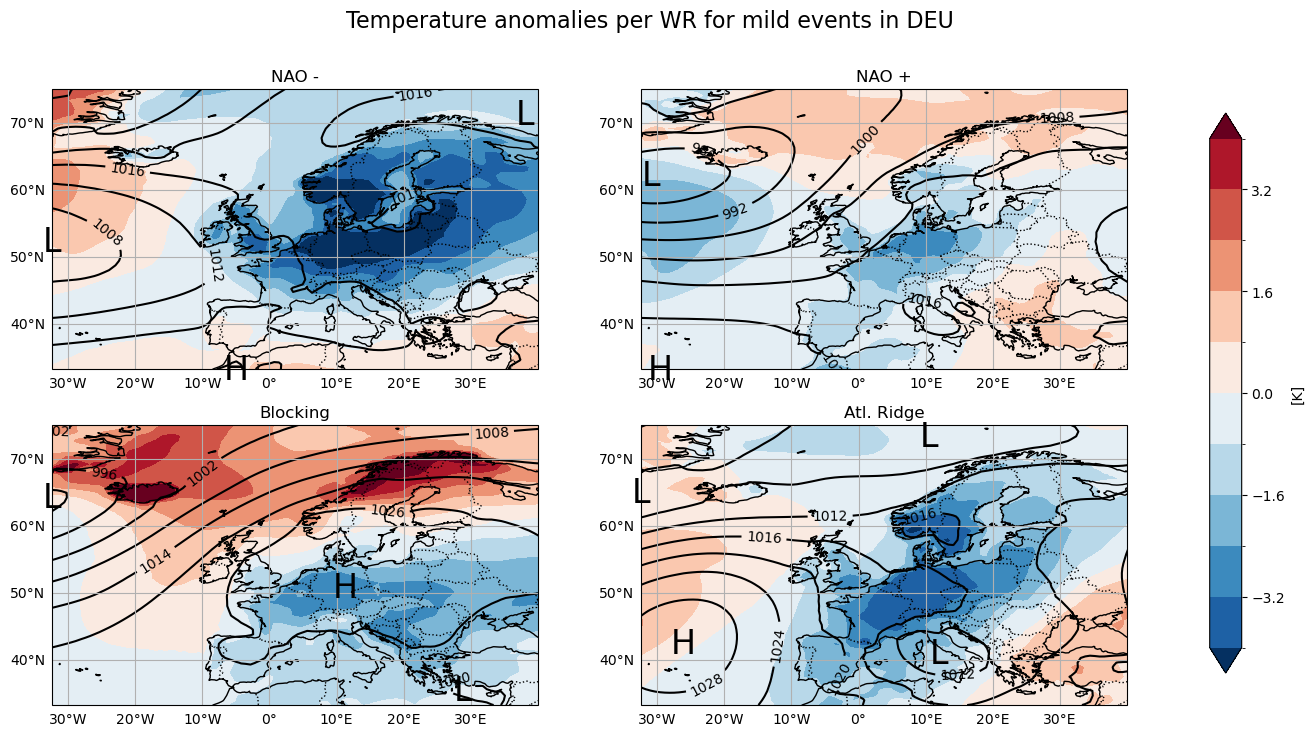

In [16]:
plot_weather_regimes('DEU', 'mild', *plot_args)

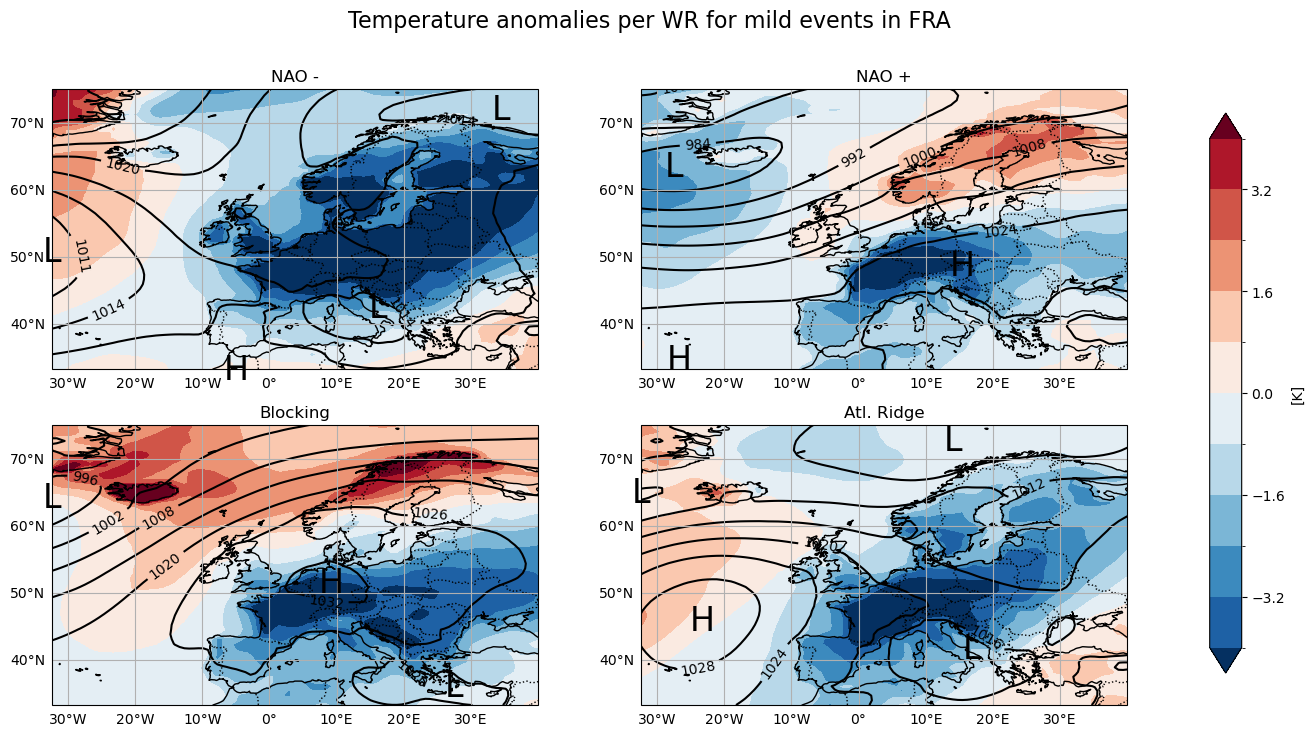

In [17]:
plot_weather_regimes('FRA', 'mild', *plot_args)

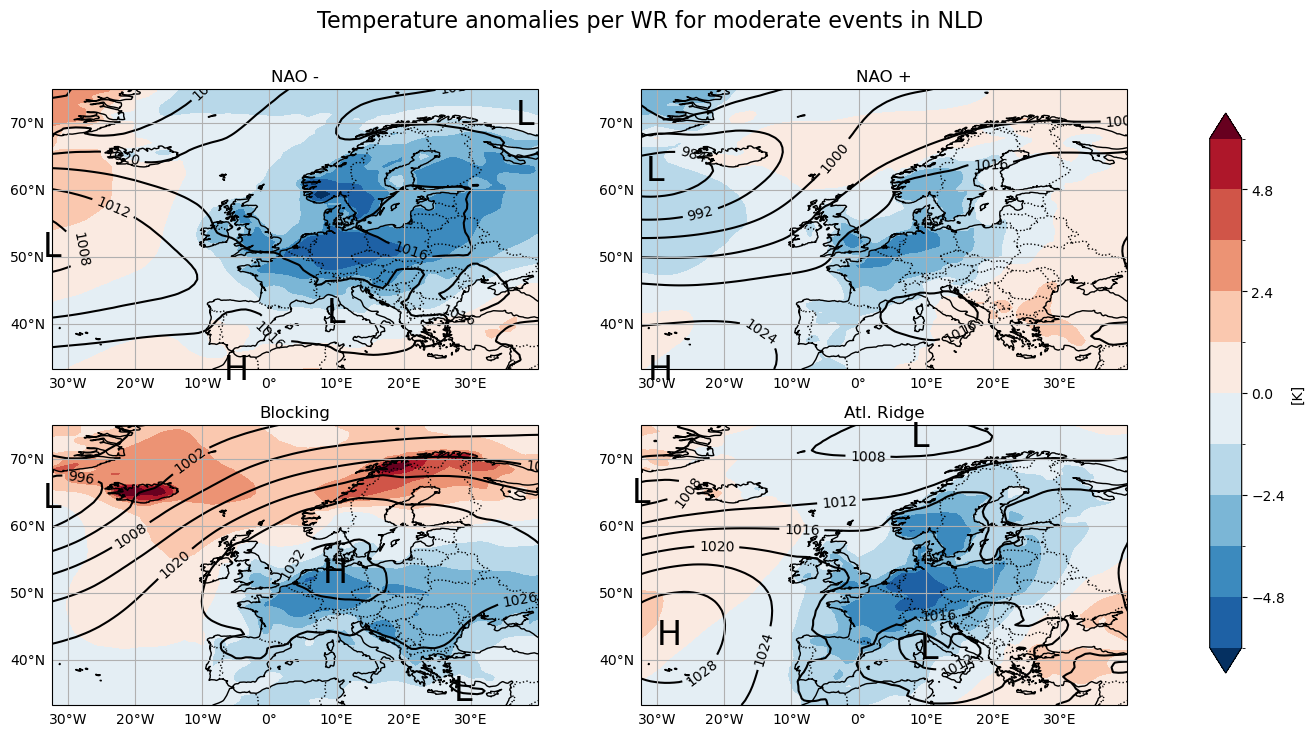

In [18]:
plot_weather_regimes('NLD', 'moderate', *plot_args)

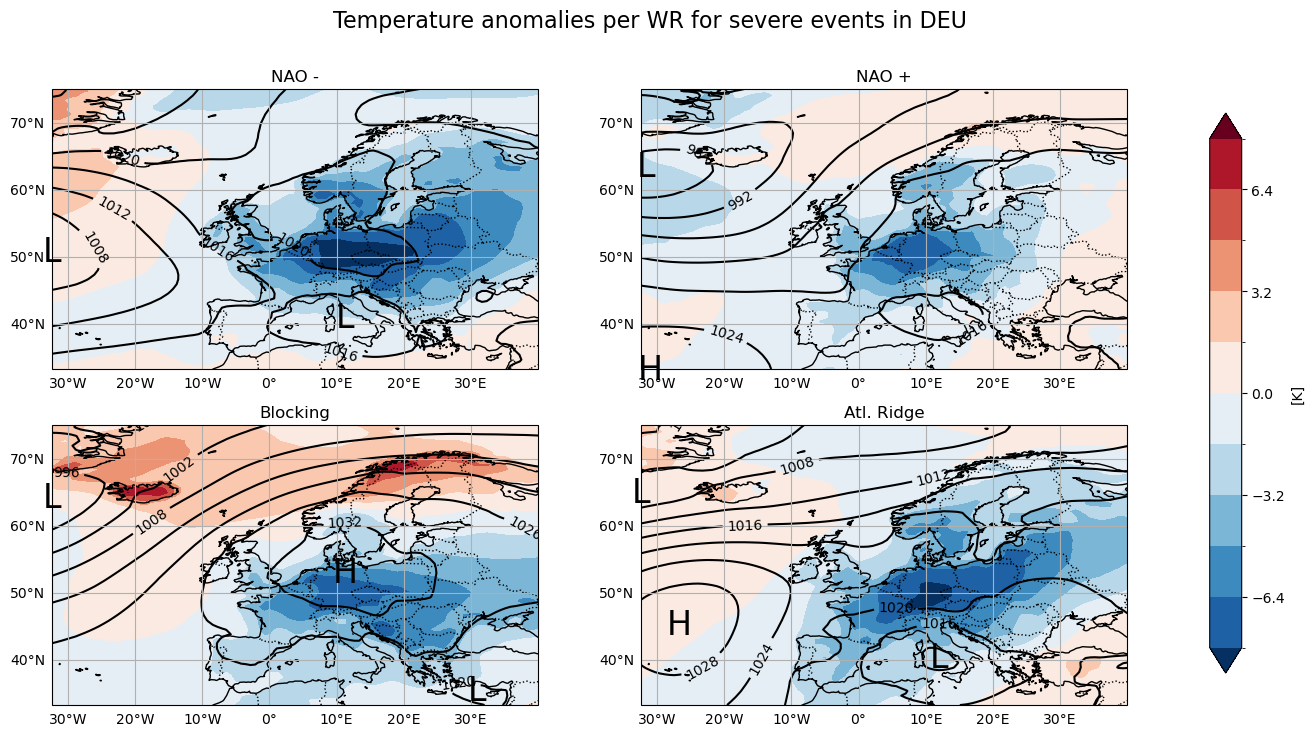

In [19]:
plot_weather_regimes('DEU', 'severe', *plot_args)

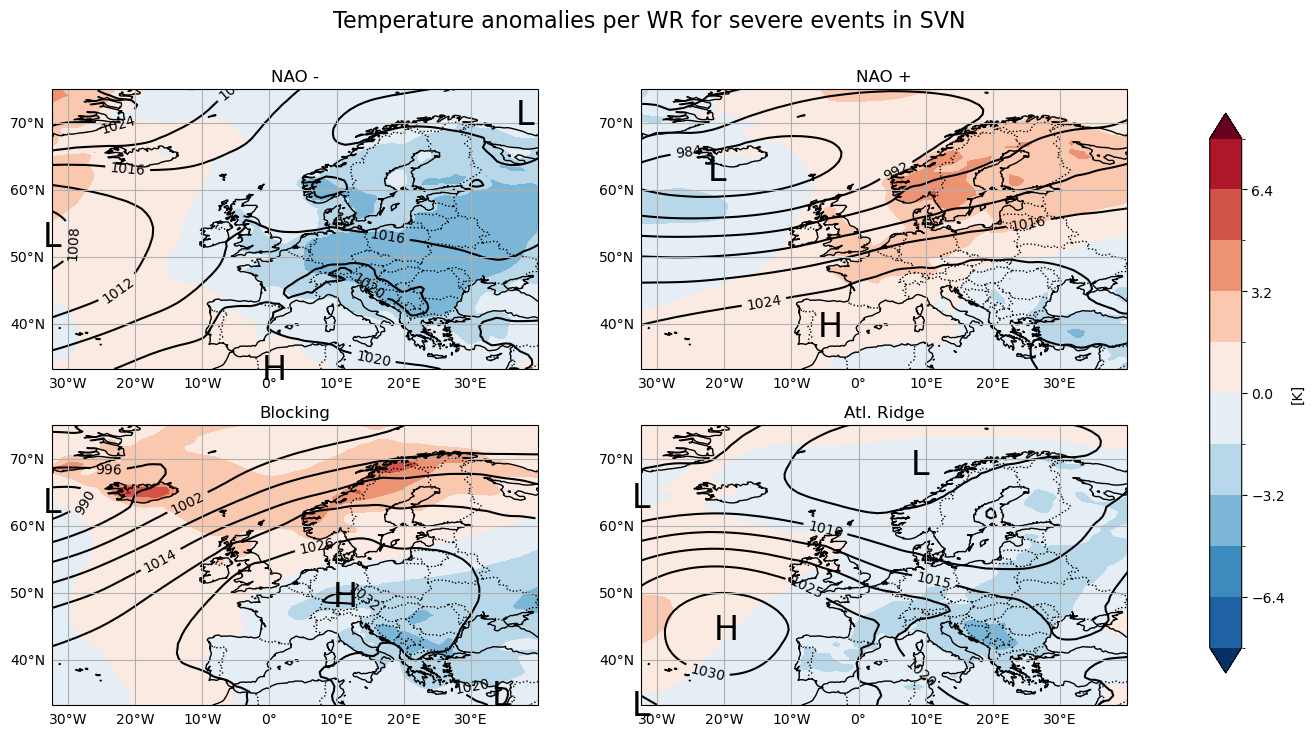

In [20]:
plot_weather_regimes('SVN', 'severe', *plot_args)

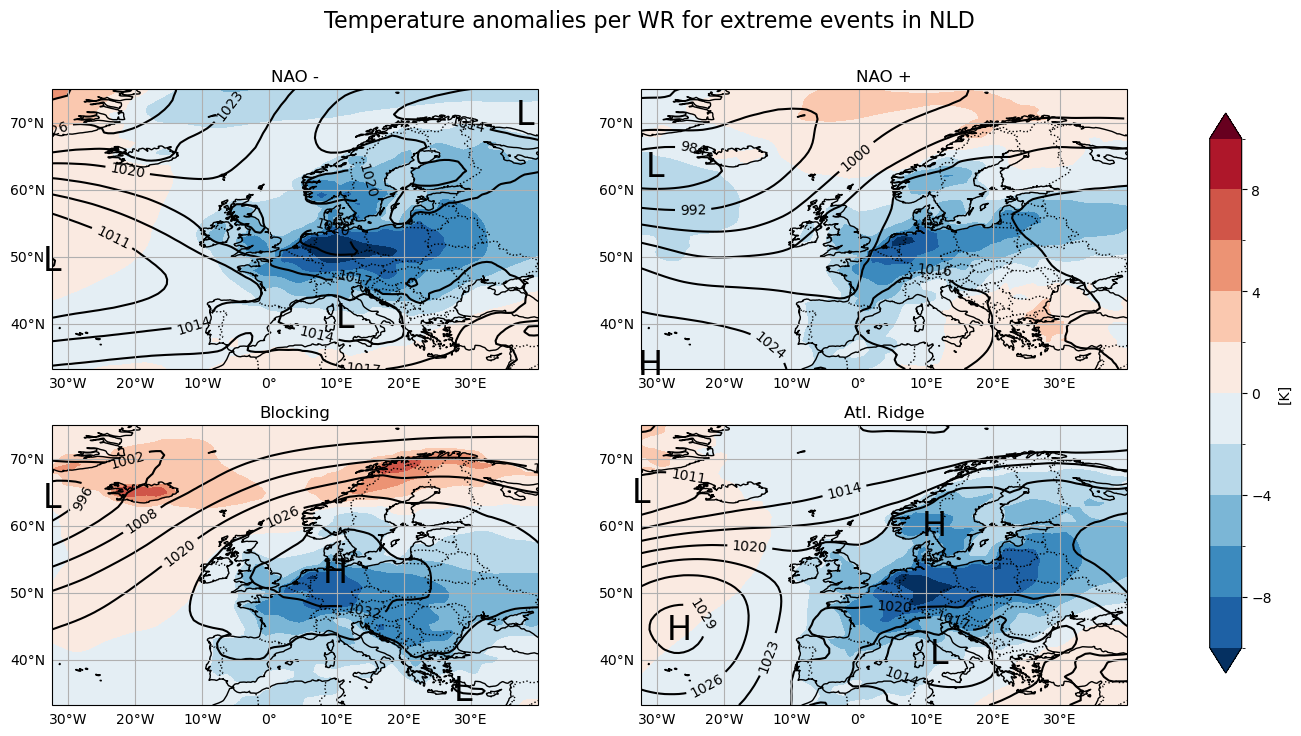

In [21]:
plot_weather_regimes('NLD', 'extreme', *plot_args)